In [1]:
#%matplotlib ipympl
%load_ext autoreload
%autoreload 2
import grimpfunc as grimp
import nisardev as nisar
import panel as pn
pn.extension()
#from matplotlib import colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os
import matplotlib.pyplot as plt
import numpy as np
import dask
from dask.diagnostics import ProgressBar
ProgressBar().register()
dask.config.set(num_workers=2)  # Avoid too many NSIDC connections
import matplotlib.gridspec as gridspec

# Set path for gdal 
env = dict(GDAL_HTTP_COOKIEFILE = os.path.expanduser('~/.grimp_download_cookiejar.txt'),
            GDAL_HTTP_COOKIEJAR = os.path.expanduser('~/.grimp_download_cookiejar.txt'))
os.environ.update(env)
# Get login
myLogin = grimp.NASALogin()  # If login appears not to work, try rerunning this cell
myLogin.username = '###' # Your username
myLogin.password = '###' # Your password
myLogin.view()

Getting login from ~/.netrc
Already logged in. Proceed.


In [2]:
import geopandas as gpd

gdf=gpd.read_file("C:/Users/r134p694_a/practice/SEG_Fjords/SEG_Fjords_v10.shp")
gdf1=gdf
gdf2=gdf1.explode()

C:\Users\r134p694_a\AppData\Local\Temp\ipykernel_37328\3397143139.py:5: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  gdf2=gdf1.explode()


In [3]:
gdf2 = gdf2.to_crs(epsg=3413)
gdf2

OBJECTID_1          Name       AreaKM  FjordID  Shape_Leng  Shape_Area  \
0  0           1        KIALEQ   348.063647       23    6.254204    0.070007   
   1           1        KIALEQ   348.063647       23    6.254204    0.070007   
1  0           2  Tingmiarmiut  1079.015818       40   19.926715    0.179119   
2  0           3      Koge Bay   352.066193       32    3.352452    0.064703   
3  0           4     Jens Munk   979.173202       33    9.551306    0.178193   
...          ...           ...          ...      ...         ...         ...   
48 0          49          None    99.882650        4    1.594527    0.022652   
49 0          50          None   117.619453        3    1.531864    0.026914   
50 0          51          None   110.475607        2    1.919556    0.025471   
51 0          52          None   200.494347        1    2.866816    0.046837   
   1          52          None   200.494347        1    2.866816    0.046837   

                                               geometry  
0  0  POLYGON ((480891.016 -2499872.703, 481054.310 ...  
   1  POLYGON ((502354.865 -2456479.479, 502943.293 ...  
1  0  POLYGON ((177152.550 -2975052.409, 177147.140 ...  
2  0  POLYGON ((210055.129 -2724033.108, 210145.162 ...  
3  0  POLYGON ((205440.776 -2750397.737, 206918.528 ...  
...                                                 ...  
48 0  POLYGON ((777729.789 -2109310.903, 778128.658 ...  
49 0  POLYGON ((804329.371 -2088078.345, 804336.687 ...  
50 0  POLYGON ((799521.626 -2065790.718, 799748.594 ...  
51 0  POLYGON ((832320.132 -2036506.395, 832020.249 ...  
   1  POLYGON ((832320.132 -2036506.395, 832364.893 ...  

[95 rows x 7 columns]

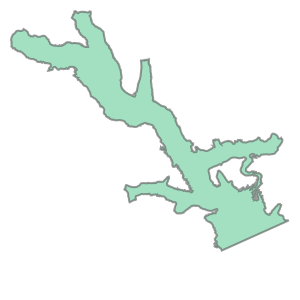

In [4]:
gdf2['geometry'][34][0]

# For fjord 30 training image

In [42]:
myImageUrls = grimp.cmrUrls(mode='image')  # mode image restricts search to the image products
myImageUrls.initialSearch(firstDate='2022-01-01', lastDate='2022-12-31', productFilter='sigma0') # change the time window as needed
# selecting productFilter='sigma0' or 'gamma0' gives you Sigma0 or Gamma0 images which might be better for digital processing
# "image" is a "visualization" product

myImageSeries = nisar.nisarImageSeries()  # Instantiate the series object
myImageSeries.readSeriesFromTiff(myImageUrls.getCogs(), chunkSize=2048/2)  # In this case increasing the chunksize can improve performance
myImageSeries.subset  

bnds=gdf2["geometry"][27][3].bounds

bbox = {'minx': bnds[0], 'miny': bnds[1], 'maxx': bnds[2], 'maxy': bnds[3]} 
xbox = np.array([bbox[x] for x in ['minx', 'minx', 'maxx', 'maxx', 'minx']]) * 0.001
ybox = np.array([bbox[y] for y in ['miny', 'maxy', 'maxy', 'miny', 'miny']]) * 0.001

myImageSeries.subSetImage(bbox)
myImageSeries.loadRemote()
myImageSeries.subset
year=2022
fjord=30
gpd2 = gpd.GeoDataFrame(gdf2["geometry"][27][3:4])
temp=myImageSeries.subset.rio.clip(gpd2.geometry.values,gpd2.crs,drop=True,invert=False)

[########################################] | 100% Completed | 30.84 s


In [35]:
print(temp.time[0].values.astype('datetime64[D]'))

2018-12-31


In [44]:
import matplotlib.pyplot as plt
from skimage import io, color, filters, exposure
import numpy as np
import cv2

# Normalize function to convert dB values to 8-bit range
def normalize_to_8bit(data, min_val=-29.99, max_val=29.9):
    norm_data = (data - min_val) / (max_val - min_val) * 255
    return np.clip(norm_data, 0, 255).astype(np.uint8)

# Function to check if an image is blank
def is_blank_image(image):
    return np.all(image == image[0, 0, :])

for i in range(len(temp.time)):
    temp1 = temp.sel(time=temp.time[i]).values.transpose(1, 2, 0)
    tbi = np.repeat(temp1, 3, axis=2)  # Create a three-band image

    # Normalize the sigma naught values to 8-bit range
    tbi_normalized = normalize_to_8bit(tbi)

    # Check if the image is blank
    if is_blank_image(tbi_normalized):
        print(f"Image {i} is blank. Skipping save.")
        continue

    # Save the image using matplotlib
    cv2.imwrite(f"Test Images/image_{i}_{temp.time[i].values.astype('datetime64[D]')}_{fjord}.png", tbi_normalized)

C:\Users\r134p694_a\AppData\Local\Temp\ipykernel_37328\2356335019.py:9: RuntimeWarning: invalid value encountered in cast
  return np.clip(norm_data, 0, 255).astype(np.uint8)


## window mask applied 

In [5]:
import numpy as np
from skimage.color import rgb2gray
from skimage.feature import graycomatrix, graycoprops
from skimage.io import imread
from PIL import Image
import matplotlib.pyplot as plt

# Function to load images from a folder
def load_images(folder_path):
    images = []
    file_names = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.png'):  # Adjust the file extension if necessary
            file_path = os.path.join(folder_path, file_name)
            image = np.array(Image.open(file_path))  # Load the image as a numpy array
            images.append(image)
            file_names.append(file_name)
    return images, file_names

folder_path = 'Train Images'
images, file_names = load_images(folder_path)

def extract_windows_and_features(image, mask, window_size, quantization, displacement, angles):
    if image.ndim == 3:
        image = rgb2gray(image)
    
    image_normalized = (image - image.min()) / (image.max() - image.min())
    image_quantized = (image_normalized * (quantization - 1)).astype(np.uint8)
    
    windows = []
    features_list = []
    positions = []
    
    for i in range(0, image.shape[0] - window_size + 1, window_size):
        for j in range(0, image.shape[1] - window_size + 1, window_size):
            window = image_quantized[i:i + window_size, j:j + window_size]
            window_mask = mask[i:i + window_size, j:j + window_size]
            
            if np.sum(window_mask) < window_size * window_size * 0.5:
                continue
            
            glcm = graycomatrix(window, distances=[displacement], angles=angles, levels=quantization, symmetric=True, normed=True)
            dissimilarity = graycoprops(glcm, 'dissimilarity').mean(axis=1)
            homogeneity = graycoprops(glcm, 'homogeneity').mean(axis=1)
            glcm_mean = np.mean(window)
            
            features = np.hstack([dissimilarity, homogeneity, glcm_mean])
            
            windows.append(window)
            features_list.append(features)
            positions.append((i, j))
    
    return np.array(windows), np.array(features_list), positions

def prepare_dataset(images, window_size, quantization, displacement, angles):
    windows_list = []
    features_list = []
    positions_list = []
    
    for image in images:
        mask = image != 0
        windows, features, positions = extract_windows_and_features(image, mask, window_size, quantization, displacement, angles)
        windows_list.extend(windows)
        features_list.extend(features)
        positions_list.extend(positions)
    
    return np.array(windows_list), np.array(features_list), positions_list

window_size = 16
quantization = 64
displacement = 1
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

windows, features, positions = prepare_dataset(images, window_size, quantization, displacement, angles)


C:\Users\r134p694_a\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Additional GLCM features included(if at all needed)

In [88]:
import numpy as np
from skimage.color import rgb2gray
from skimage.feature import graycomatrix, graycoprops
from skimage.io import imread
from PIL import Image
import matplotlib.pyplot as plt

# Function to load images from a folder
def load_images(folder_path):
    images = []
    file_names = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.png'):  # Adjust the file extension if necessary
            file_path = os.path.join(folder_path, file_name)
            image = np.array(Image.open(file_path))  # Load the image as a numpy array
            images.append(image)
            file_names.append(file_name)
    return images, file_names

folder_path = 'Train Images'
images, file_names = load_images(folder_path)

def extract_windows_and_features(image, mask, window_size, quantization, displacement, angles):
    if image.ndim == 3:
        image = rgb2gray(image)
    
    image_normalized = (image - image.min()) / (image.max() - image.min())
    image_quantized = (image_normalized * (quantization - 1)).astype(np.uint8)
    
    windows = []
    features_list = []
    positions = []
    
    for i in range(0, image.shape[0] - window_size + 1, window_size):
        for j in range(0, image.shape[1] - window_size + 1, window_size):
            window = image_quantized[i:i + window_size, j:j + window_size]
            window_mask = mask[i:i + window_size, j:j + window_size]
            
            if np.sum(window_mask) < window_size * window_size * 0.5:
                continue
            
            glcm = graycomatrix(window, distances=[displacement], angles=angles, levels=quantization, symmetric=True, normed=True)
            
            # Extract GLCM features
            contrast = graycoprops(glcm, 'contrast').mean(axis=1)
            dissimilarity = graycoprops(glcm, 'dissimilarity').mean(axis=1)
            homogeneity = graycoprops(glcm, 'homogeneity').mean(axis=1)
            ASM = graycoprops(glcm, 'ASM').mean(axis=1)
            energy = graycoprops(glcm, 'energy').mean(axis=1)
            correlation = graycoprops(glcm, 'correlation').mean(axis=1)
            
            # Combine all features into one array
            features = np.hstack([contrast, dissimilarity, homogeneity, ASM, energy, correlation])
            
            windows.append(window)
            features_list.append(features)
            positions.append((i, j))
    
    return np.array(windows), np.array(features_list), positions


def prepare_dataset(images, window_size, quantization, displacement, angles):
    windows_list = []
    features_list = []
    positions_list = []
    
    for image in images:
        mask = image != 0
        windows, features, positions = extract_windows_and_features(image, mask, window_size, quantization, displacement, angles)
        windows_list.extend(windows)
        features_list.extend(features)
        positions_list.extend(positions)
    
    return np.array(windows_list), np.array(features_list), positions_list

window_size = 16
quantization = 64
displacement = 1
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

windows, features, positions = prepare_dataset(images, window_size, quantization, displacement, angles)


In [89]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model

# Define input shapes
image_input_shape = (window_size, window_size, 1)  # Image windows
features_input_shape = (features.shape[1],)  # GLCM features

# Image window branch
image_input = Input(shape=image_input_shape)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(image_input)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)

# GLCM features branch
features_input = Input(shape=features_input_shape)
y = Dense(128, activation='relu')(features_input)
y = Dropout(0.2)(y)
y = Dense(256, activation='relu')(y)
y = Dropout(0.2)(y)
y = Dense(128, activation='relu')(y)
y = Dropout(0.2)(y)

# Combine both branches
combined = Concatenate()([x, y])
z = Dense(128, activation='relu')(combined)
z = Dropout(0.2)(z)
z = Dense(64, activation='relu')(z)
z = Dropout(0.2)(z)
output = Dense(1, activation='sigmoid')(z)  # Binary classification

# Define the model
model = Model(inputs=[image_input, features_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 16, 16, 1)]          0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 16, 16, 64)           640       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_4 (Bat  (None, 16, 16, 64)           256       ['conv2d_4[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 8, 8, 64)             0         ['batch_normalization_4[

In [90]:
from sklearn.cluster import KMeans

# Combine windows and features into a single dataset for clustering
combined_data = np.concatenate([windows.reshape(windows.shape[0], -1), features], axis=1)

# Apply K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
pseudo_labels = kmeans.fit_predict(combined_data)

# Map cluster labels to sea ice (1) and water (0) based on some initial inspection or domain knowledge
# For simplicity, assuming cluster 0 is water and cluster 1 is sea ice
pseudo_labels = (pseudo_labels == 0).astype(int)


C:\Users\r134p694_a\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [92]:
# Train the model with pseudo-labels
model.fit([windows, features], pseudo_labels, epochs=10, batch_size=32)

Epoch 1/10
8932/8932 [==============================] - 99s 11ms/step - loss: 0.1198 - accuracy: 0.9504
Epoch 2/10
8932/8932 [==============================] - 101s 11ms/step - loss: 0.1035 - accuracy: 0.9566
Epoch 3/10
8932/8932 [==============================] - 102s 11ms/step - loss: 0.0964 - accuracy: 0.9592
Epoch 4/10
8932/8932 [==============================] - 102s 11ms/step - loss: 0.0910 - accuracy: 0.9619
Epoch 5/10
8932/8932 [==============================] - 103s 11ms/step - loss: 0.0838 - accuracy: 0.9646
Epoch 6/10
8932/8932 [==============================] - 104s 12ms/step - loss: 0.0791 - accuracy: 0.9661
Epoch 7/10
8932/8932 [==============================] - 100s 11ms/step - loss: 0.0736 - accuracy: 0.9690
Epoch 8/10
8932/8932 [==============================] - 100s 11ms/step - loss: 0.0724 - accuracy: 0.9693
Epoch 9/10
8932/8932 [==============================] - 100s 11ms/step - loss: 0.0713 - accuracy: 0.9701
Epoch 10/10
8932/8932 [==============================] -

In [300]:
def extract_windows_and_features_for_prediction(image, window_size, quantization, displacement, angles):
    if image.ndim == 3:
        image = rgb2gray(image)

    image_normalized = (image - image.min()) / (image.max() - image.min())
    image_quantized = (image_normalized * (quantization - 1)).astype(np.uint8)

    windows = []
    features_list = []
    positions = []

    for i in range(0, image.shape[0] - window_size + 1, window_size):
        for j in range(0, image.shape[1] - window_size + 1, window_size):
            window = image_quantized[i:i + window_size, j:j + window_size]
            glcm = graycomatrix(window, distances=[displacement], angles=angles, levels=quantization, symmetric=True, normed=True)
            dissimilarity = graycoprops(glcm, 'dissimilarity').mean(axis=1)
            homogeneity = graycoprops(glcm, 'homogeneity').mean(axis=1)
            glcm_mean = np.mean(window)
            features = np.hstack([dissimilarity, homogeneity, glcm_mean])
            windows.append(window)
            features_list.append(features)
            positions.append((i, j))

    return np.array(windows), np.array(features_list), positions

# Example: Extracting windows and features for a test image
test_image = np.array(Image.open('Train Images/image_0_2019_30.png'))
test_windows, test_features, positions = extract_windows_and_features_for_prediction(test_image, window_size, quantization, displacement, angles)


In [95]:
def extract_windows_and_features_for_prediction(image, mask, window_size, quantization, displacement, angles):
    if image.ndim == 3:
        image = rgb2gray(image)

    image_normalized = (image - image.min()) / (image.max() - image.min())
    image_quantized = (image_normalized * (quantization - 1)).astype(np.uint8)

    windows = []
    features_list = []
    positions = []

    for i in range(0, image.shape[0] - window_size + 1, window_size):
        for j in range(0, image.shape[1] - window_size + 1, window_size):
            window = image_quantized[i:i + window_size, j:j + window_size]
            window_mask = mask[i:i + window_size, j:j + window_size]
            
            if np.sum(window_mask) < window_size * window_size * 0.5:
                continue  # Skip windows where the mask is not sufficiently covered
            
            glcm = graycomatrix(window, distances=[displacement], angles=angles, levels=quantization, symmetric=True, normed=True)
            dissimilarity = graycoprops(glcm, 'dissimilarity').mean(axis=1)
            homogeneity = graycoprops(glcm, 'homogeneity').mean(axis=1)
            glcm_mean = np.mean(window)
            features = np.hstack([dissimilarity, homogeneity, glcm_mean])
            
            windows.append(window)
            features_list.append(features)
            positions.append((i, j))

    return np.array(windows), np.array(features_list), positions


test_image = np.array(Image.open('Test Images/image_21_2022-09-08_30.png'))
test_mask = test_image != 0 
test_windows, test_features, positions = extract_windows_and_features_for_prediction(test_image, test_mask, window_size, quantization, displacement, angles)


### With added GLCM Features

In [97]:
def extract_windows_and_features_for_prediction(image, mask, window_size, quantization, displacement, angles):
    if image.ndim == 3:
        image = rgb2gray(image)

    image_normalized = (image - image.min()) / (image.max() - image.min())
    image_quantized = (image_normalized * (quantization - 1)).astype(np.uint8)

    windows = []
    features_list = []
    positions = []

    for i in range(0, image.shape[0] - window_size + 1, window_size):
        for j in range(0, image.shape[1] - window_size + 1, window_size):
            window = image_quantized[i:i + window_size, j:j + window_size]
            window_mask = mask[i:i + window_size, j:j + window_size]
            
            if np.sum(window_mask) < window_size * window_size * 0.5:
                continue  # Skip windows where the mask is not sufficiently covered
            
            glcm = graycomatrix(window, distances=[displacement], angles=angles, levels=quantization, symmetric=True, normed=True)
            
            # Extract GLCM features
            contrast = graycoprops(glcm, 'contrast').mean(axis=1)
            dissimilarity = graycoprops(glcm, 'dissimilarity').mean(axis=1)
            homogeneity = graycoprops(glcm, 'homogeneity').mean(axis=1)
            ASM = graycoprops(glcm, 'ASM').mean(axis=1)
            energy = graycoprops(glcm, 'energy').mean(axis=1)
            correlation = graycoprops(glcm, 'correlation').mean(axis=1)
            
            # Combine all features into one array
            features = np.hstack([contrast, dissimilarity, homogeneity, ASM, energy, correlation])
            
            windows.append(window)
            features_list.append(features)
            positions.append((i, j))

    return np.array(windows), np.array(features_list), positions


# Example usage with a test image
test_image = np.array(Image.open('Test Images/image_21_2022-09-08_30.png'))
test_mask = test_image != 0 
test_windows, test_features, positions = extract_windows_and_features_for_prediction(test_image, test_mask, window_size, quantization, displacement, angles)


In [98]:
# Predict the labels for the test windows
test_predictions = model.predict([test_windows, test_features])

# Convert predictions to binary labels
test_predicted_labels = (test_predictions > 0.5).astype(int)

def map_predictions_to_image(predicted_labels, positions, image_shape, window_size):
    prediction_map = np.zeros(image_shape)

    for (i, j), label in zip(positions, predicted_labels):
        prediction_map[i:i + window_size, j:j + window_size] = label

    return prediction_map

# Create a prediction map for the test image
prediction_map = map_predictions_to_image(test_predicted_labels, positions, test_image.shape, window_size)


78/78 [==============================] - 0s 4ms/step


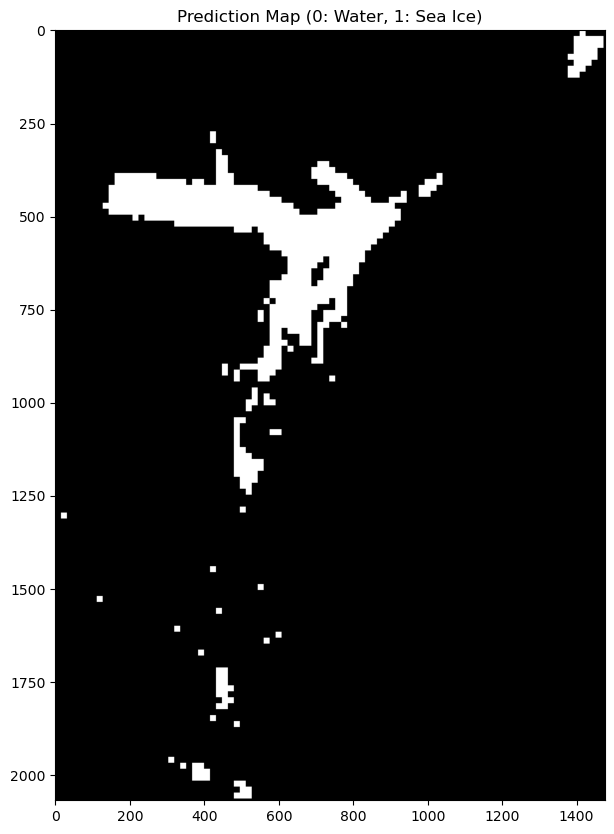

In [87]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))

#plt.subplot(2, 1, 1)
plt.imshow(test_image, cmap='gray')
plt.title('Original Test Image')

#plt.subplot(2, 1, 2)
plt.imshow(prediction_map, cmap='gray')
plt.title('Prediction Map (0: Water, 1: Sea Ice)')

plt.show()
